In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from IPython.core.display import HTML
%config InlineBackend.figure_format = 'svg'
def css_style(url):
    style = requests.get(url)
    return HTML(style.text)
css_style('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')

# Nonlinear Equations

Solving a set of nonlinear equations is finding the points at which they are equal. If the equations are written in residual form, it is equivalent to solving a set of equations where one of the equations is trivial, i.e. $y=0$. Take the equations below:

In [145]:
x = np.linspace(-3, 3, 100)
y1 = lambda x: 4*x - x**3/2
y2 = lambda x: np.sin(x)*np.exp(-x)

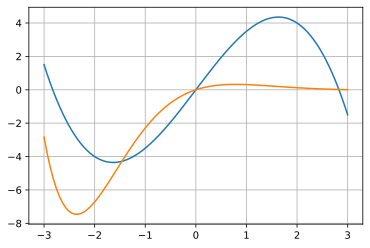

In [146]:
plt.plot(x, y1(x))
plt.plot(x, y2(x))
plt.grid(True)

To solve such a system, the residual forms of the equations can be written, and approximated by a truncated Taylor Series:

$$f(x,y)\  =\  f(x_{0},y_{0})\  +\  (x-x_{0})\frac{\partial f}{\partial x} \mid_{x_{0},y_{0}} +(y-y_{0})\frac{\partial f}{\partial y} \mid_{x_{0},y_{0}} +...$$

where we will truncate after the ellipses. Therefore, the residual function is set to zero, and we have:

$$0  \approx  f(x_{0},y_{0})\  +\  (x-x_{0})\frac{\partial f}{\partial x} \mid_{x_{0},y_{0}} +(y-y_{0})\frac{\partial f}{\partial y} \mid_{x_{0},y_{0}}$$

which can be written in matrix form:

$$\begin{bmatrix}f_{1}(x_{0},y_{0})\\ f_{2}(x_{0},y_{0}) \end{bmatrix} + \begin{bmatrix}\frac{\partial f_{1}}{\partial x} &\frac{\partial f_{1}}{\partial y} \\ \frac{\partial f_{2}}{\partial x} &\frac{\partial f_{2}}{\partial y} \end{bmatrix} \begin{bmatrix}x-x_{0}\\ y-y_{0}\end{bmatrix} =\begin{bmatrix}0\\ 0\end{bmatrix} $$

In shorhand:

$$\Delta =-J^{-1}\left( \vec{x}_{0} \right)  F\left( \vec{x}_{0} \right)  $$

We can write functions that maintain the Jacobian general by using numerical differentiation.

In [159]:
f1 = lambda x, y: y - 4*x + 0.5*x**3
f2 = lambda x, y: y - np.sin(x)*np.exp(-x)

In [170]:
# Forward Euler for a single point
def dfx(f, x, y, h):
    return (f(x+h, y)-f(x,y))/h

def dfy(f, x, y, h):
    return (f(x, y+h)-f(x,y))/h

In [220]:
def F(xval):
    x, y = xval
    return np.array([f1(x,y), f2(x,y)])

def J(func1, func2, xval):
    x, y = xval
    h = 1e-6
    A = np.array([[dfx(f1, x, y, h), dfy(f1, x, y, h)],
                  [dfx(f2, x, y, h), dfy(f2, x, y, h)]])
    return A


In [181]:
dfx(f1, -2, -4, 1e-6)

1.9999970000128542

In [218]:
xval

array([-2, -4])

In [179]:
xval = np.array([-2, -4])
F(xval)

array([0.       , 2.7188497])

In [180]:
J(f1, f2, xval)

array([[ 1.999997  ,  1.        ],
       [-3.64392045,  1.        ]])

In [184]:
def newton_solver(F, J, x, tol):
    err = tol + 100
    niter = 0
    while abs(err) > tol:
        Fval = F(x)
        Jval = J(f1, f2, x)
        Δ = np.linalg.solve(-Jval, Fval)
        x = x + Δ
        err = np.linalg.norm(F(x), np.inf)
        niter += 1
    return x, niter, err

In [222]:
[xroot, yroot], iters, error = newton_solver(F, J, xval, 1e-5)
xroot, yroot

(-1.4611085295043844, -4.284827518636318)

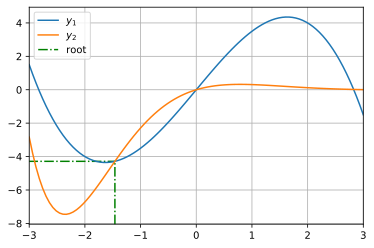

In [212]:
plt.plot(x, y1(x), label='$y_1$')
plt.plot(x, y2(x), label='$y_2$')
xmin, xmax, ymin, ymax = plt.axis()
plt.xlim([x[0], x[-1]])
plt.ylim([ymin, ymax])
plt.vlines(xroot, ymin, yroot, colors='g', linestyles='dashdot', label='root')
plt.hlines(yroot, xmin, xroot, colors='g', linestyles='dashdot')
plt.grid(True)
plt.legend()

In [213]:
from scipy.optimize import fsolve

In [215]:
fsolve(F, xval, full_output=1)

(array([-1.46110592, -4.28481694]),
 {'nfev': 11, 'fjac': array([[-0.16136959,  0.98689404],
         [-0.98689404, -0.16136959]]), 'r': array([-4.42320799,  0.80240513, -0.89587661]), 'qtf': array([-2.48019404e-10,  2.70601326e-09]), 'fvec': array([-2.40052422e-12, -6.22613072e-13])},
 1,
 'The solution converged.')

In [223]:
newton_solver(F, J, np.array([2,2]), 1e-5)

(array([2.82612678, 0.01838035]), 6, 1.1166356728153914e-10)

In [224]:
fsolve(F, np.array([2,2]))

array([2.82612678, 0.01838035])